<a href="https://colab.research.google.com/github/SergeiVKalinin/ML-ElectronMicroscopy-2023/blob/main/Lecture%204/Spectral_Processing_Lecture4_Jun16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Virtual Summer School: Machine Learning in Electron Microscopy
# Linear methods and dimensionality reduction for spectral data - June 16
### Lecture 4, June 16

- Notebook by R. Vasudevan, Oak Ridge National Laboratory
- modified by Sergei V. Kalinin, UT Knoxville
- EELS data by Kevin Roccapriore, Oak Ridge National Laboratory

In this notebook, we will cover: 
* Supervised regression
* Linear decomposition methods: PCA, NMF, ICA
* Clustering methods: K-means clustering, Gaussian mixture models


In [1]:
#Load required packages
!pip install pyNSID sidpy SciFiReaders pycroscopy wget ipympl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.0/764.0 kB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.0/340.0 kB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 

In [2]:
#Here we will download a data file
import wget
wget.download(url='https://github.com/pycroscopy/pycroscopy/blob/main/sample_data/bfo_iv_final.hf5?raw=true', 
              out = 'bfo_iv_final.hf5');

In [3]:
# Import some packages - we will need numpy and matplotlib to start with
import numpy as np
import matplotlib.pyplot as plt

colab = True #Set to True if in Google Colab, else set to False
if colab:
    %matplotlib widget
    from google.colab import output
    output.enable_custom_widget_manager()
else:
    %matplotlib notebook

# First example - generic signal processing and supervised regression


To begin with, we will first just create some 'fake' data so that we can explore different methods of decomposition on it. The advantage is that we know the true underlying function, so it is easy to compare with the 'ground truth' as it were. However this is still applicable to any generic spectral data captured in electron microscopy

For simplicity, we will let it be composed of sine functions of different frequencies and phases, and add some noise to make it realistic.
    
    
$y = sin(2\pi f_1 t + \phi_1) +  sin(2\pi f_2 t + \phi_2) +\epsilon$

<p>
where $\epsilon$ is some noise

</font>

In [4]:
f1 = 2.2 #frequency of wave 1
f2 = 1.6 #frequency of wave 2

phi_1 = np.pi/4 #phase of wave 1
phi_2 = np.pi/6 #phase of wave 2

t = np.linspace(0,10,500) #time vector
k = 0.20 #noise factor. Increase to make observations more noisy.

wave_1 = np.sin(2*np.pi*f1*t + phi_1) +  k * np.random.normal(size=t.size) #generate wave 1 with noise
wave_2 = np.sin(2*np.pi*f2*t + phi_2) +  k * np.random.normal(size=t.size) #generate wave 2 with noise

y = wave_1 + wave_2 #observations


# Plot the data

Text(0.5, 1.0, 'k = 0.2')

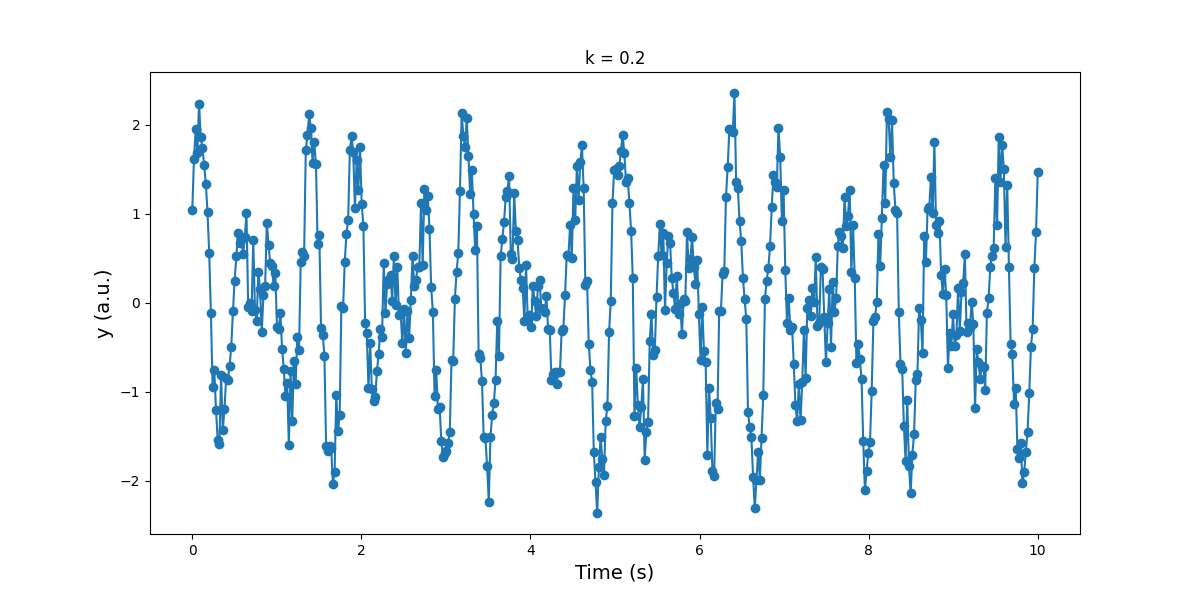

In [5]:
#Let's plot this to see what it looks like

fig, axes  = plt.subplots(figsize = (12,6))
axes.plot(t, y, marker = 'o', linestyle = '-')
axes.set_xlabel('Time (s)', fontsize = 14)
axes.set_ylabel('y (a.u.)', fontsize = 14)
axes.set_title('k = ' + str(k))

# Let's do some filtering

There are numerous ways to filter noisy spectral data. The basic ones include generic signal filters, such as median, Savitzky-Golay and Wiener. These are all available in scipy.filter module. These are window based filters that take as input a window size. 

Let's see how all of these perform

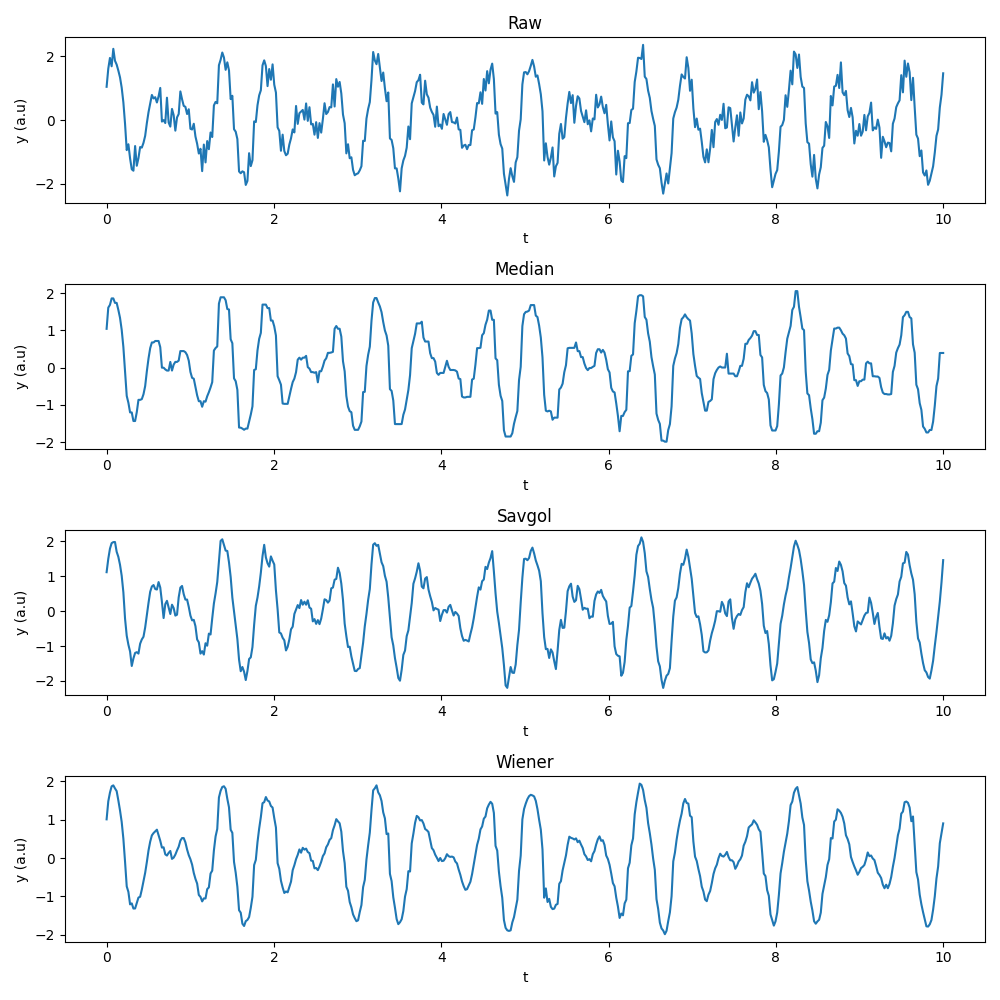

In [6]:
#Import the filters
from scipy.signal import medfilt, savgol_filter, wiener

#Filter the data
median_filtered_data = medfilt(y, kernel_size = 5) #the kernel size is the window size
savgol_filtered_data = savgol_filter(y, window_length = 5, polyorder=2) #There are more options available for this filter. Try them!
wiener_filtered_data = wiener(y, mysize = 5)


all_data = [y, median_filtered_data, savgol_filtered_data, wiener_filtered_data]
labels = ['Raw', 'Median', 'Savgol','Wiener']

#Let's see how they all performed

fig, axes = plt.subplots(nrows=4, ncols = 1, figsize = (10,10))
for ydata, label, ax in zip(all_data, labels, axes.flat):
                                       
    ax.plot(t, ydata)
    ax.set_title(label)
    ax.set_xlabel('t')
    ax.set_ylabel('y (a.u)')

fig.tight_layout()

### Exercise: Change the window size and see what happens to the signal

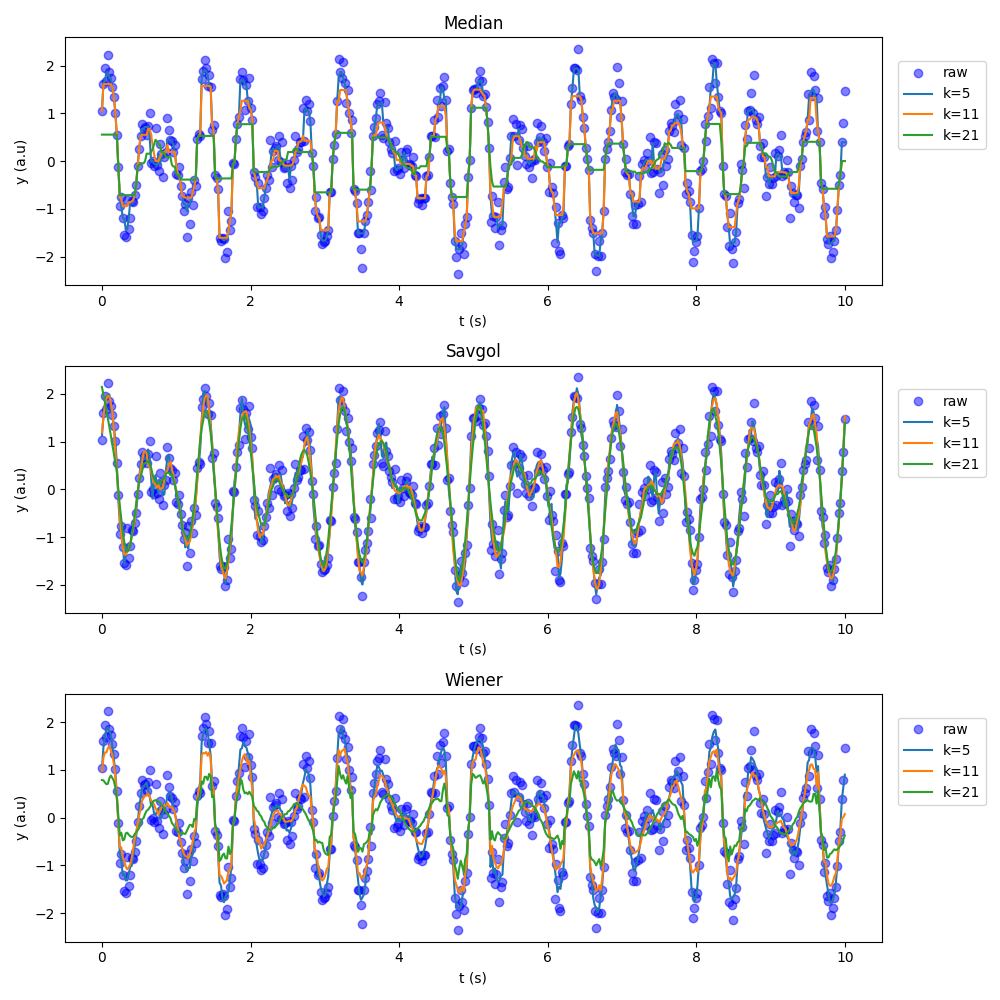

In [7]:
#Let's see what happens if we change window sizes

#Solution
k_sizes = [5,11,21]
filtered_data = []
for k_size in k_sizes:
    median_filtered_data = medfilt(y, kernel_size = k_size) #the kernel size is the window size
    savgol_filtered_data = savgol_filter(y, window_length = k_size, polyorder=2) #There are more options available for this filter. Try them!
    wiener_filtered_data = wiener(y, mysize = k_size)
    filtered_data.append([median_filtered_data,savgol_filtered_data,wiener_filtered_data])

filtered_data = np.array(filtered_data)
labels = ['Median', 'Savgol','Wiener']

#Let's see how they all performed

fig, axes = plt.subplots(nrows=3, ncols = 1, figsize = (10,10))
for ind in range(3):
    ax = axes.flat[ind]
    ax.plot(t, y, 'bo', label = 'raw', alpha = 0.5)
    ydata_s = filtered_data[:,ind]
    for l in range(len(k_sizes)):
        ax.plot(t,ydata_s[l,:], label = 'k={}'.format(k_sizes[l]))
    ax.set_title(labels[ind])
    ax.set_xlabel('t (s)')
    ax.set_ylabel('y (a.u)')
    ax.legend(loc=[1.02, 0.55])

fig.tight_layout()

# Fourier Filtering

A key insight into signal processing is that it helps a lot more if you know something about the nature of the signal. In this case, the signal is periodic. Such prior knowledge is invaluable because it can be effectively used to better recover the true signal from noisy observations. So, given this function is periodic, perhaps a moving window is not the right choice (see for instance, the poor performance of the Median filter). A more appropriate method is to use Fourier filtering, which assumes the signal is periodic and tries to recover the components (i.e., frquencies present). 

Text(0.5, 1.0, 'Fourier Transform of y (amplitide)')

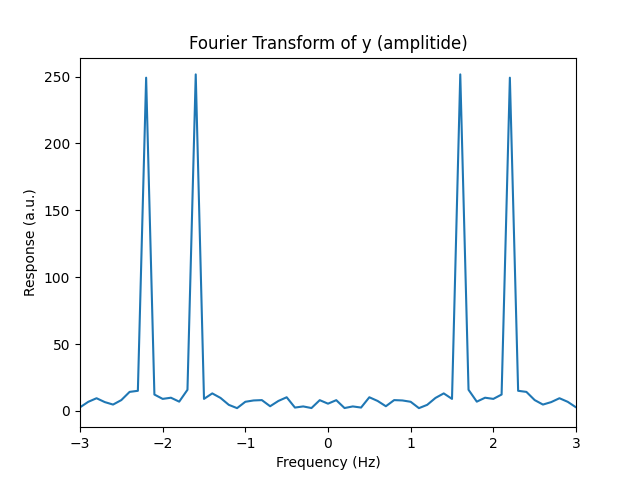

In [8]:
#let's calculate the Fourier transform

fft_y = np.fft.fft(y) #Do the Fourier transformation

#By default the transformation does not put the lower frequencies at the center. To fix this, we can use fftshift
#this will ensure that our signal has the low frequency components at the center, and the high frequencies at the edges

fft_y_shift = np.fft.fftshift(fft_y) 

'''
It is important to create the frequency vector, which requires us to know the sampling rate. 
The sampling rate is the number of points measured per second. In our case, this can be calcualted easily
by determining the number of seconds (10), and the total number of measured pixels (t.size).

'''
w_vec = np.linspace(-0.5*t.size/max(t), 0.5*t.size/max(t) - t.size/max(t)/t.size,t.size) #generate frequency vector

fig, axes = plt.subplots()
axes.plot(w_vec, np.abs(fft_y_shift))
axes.set_xlim([-3,3])
axes.set_xlabel ('Frequency (Hz)')
axes.set_ylabel ('Response (a.u.)')
axes.set_title('Fourier Transform of y (amplitide)')


In [9]:
#Find the two peaks.
#We can use the sort algorithm, which sorts data from the smallest to largest

#Get the absolute values only
abs_fft_shift = np.abs(fft_y_shift)

#Sort the data from smallest to largest. Use of argsort gives the indices, instead of the values
#This will be required for us.

sorted_maxima_ascending = np.argsort(abs_fft_shift) 

#Since we want the maximum, not the minimum, we should sort the array in descending order.
#This can easily be done by reversing the order, which is done below using numpy's indexing functionality.

sorted_maxima_descending = sorted_maxima_ascending[::-1] 


In [10]:
#Let's list the frequencies of the top ten amplitudes
w_vec[sorted_maxima_descending[:10]]

array([  1.6,  -1.6,  -2.2,   2.2,   1.7,  -1.7,  24.5, -24.5,  -2.3,
         2.3])

# Reconstruct via use of the first two Fourier components

In [11]:
#let's reconstruct the signal based on the first two Fourier peaks
#for that we need the phases also. We can get this by using np.angle
phase_vals = np.angle(fft_y_shift)
phase_1 = phase_vals[[sorted_maxima_descending[0]]] #Here we take the frequency at which the maximum amplitude occurs, 
                                            #and then get the associated phase
phase_2 = phase_vals[[sorted_maxima_descending[2]]] #Same, for the second one.

y1 = np.sin(2*np.pi*t*w_vec[sorted_maxima_descending[0]] + phase_1)
y2 = np.sin(2*np.pi*t*w_vec[sorted_maxima_descending[2]] + phase_2)

y_fft_recon = y1 + y2


# Let's Plot the FFT Filtered Signal

Text(0, 0.5, 'y (a.u.)')

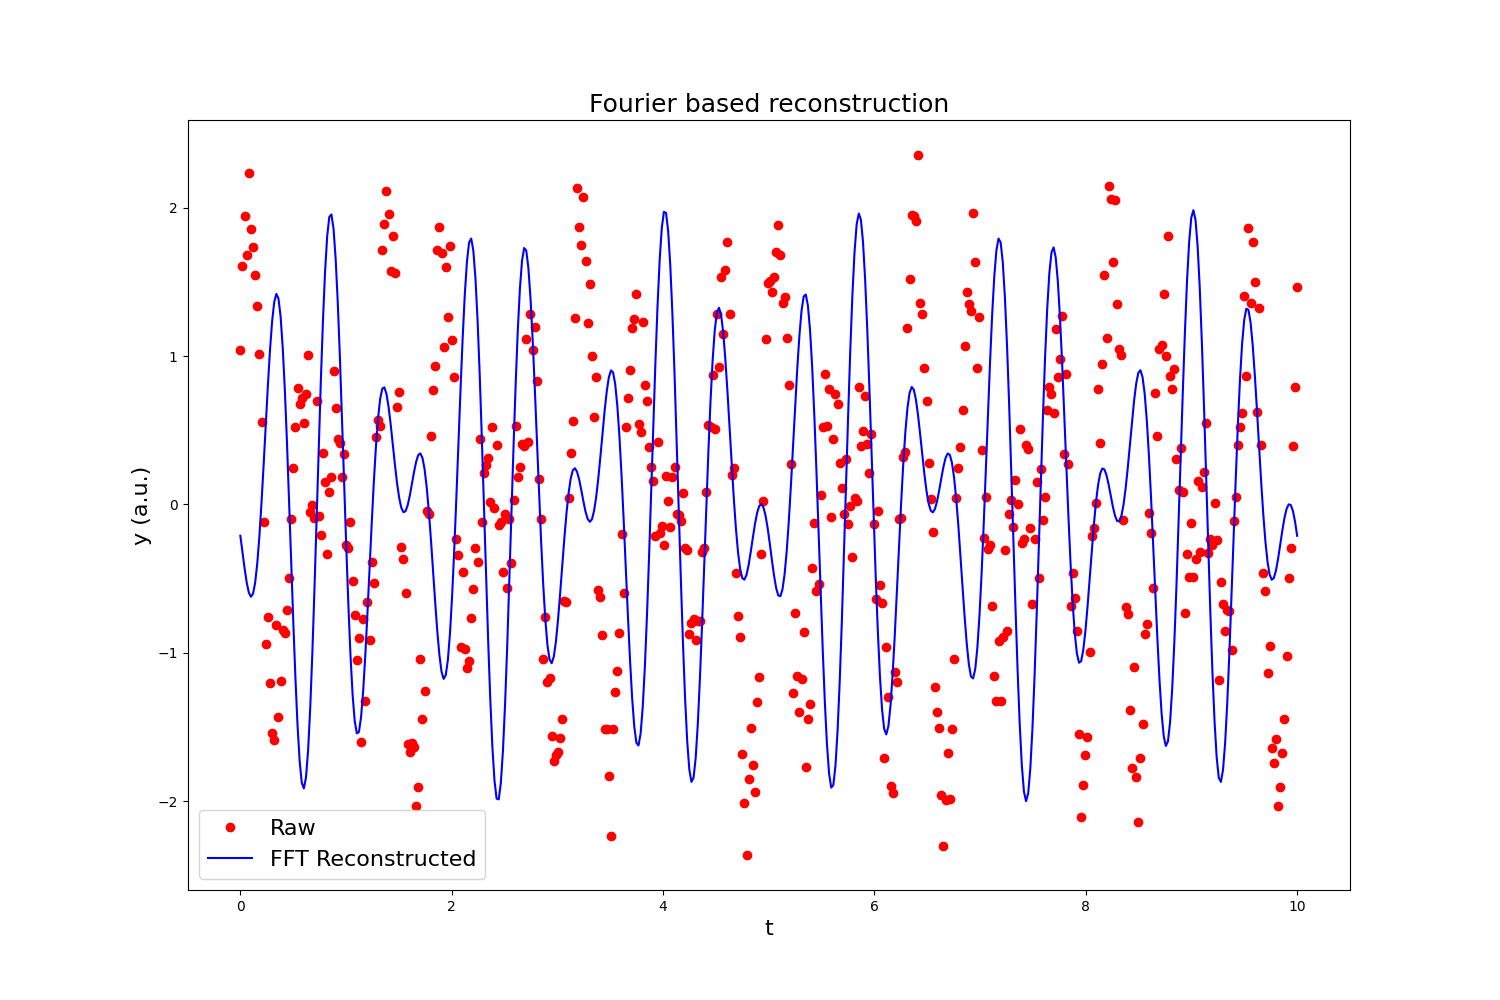

In [12]:
fig, axes = plt.subplots(figsize = (15,10))
axes.plot(t,y, 'ro', label = 'Raw')
axes.plot(t,y_fft_recon, 'b-', label = 'FFT Reconstructed')
axes.legend(loc = 'best', fontsize = 16)
axes.set_title('Fourier based reconstruction', fontsize = 18)
axes.set_xlabel('t', fontsize =16)
axes.set_ylabel('y (a.u.)', fontsize = 16)

# Alternative Method: Band-pass filtering

Instead of trying to reconstruct based on the two frequencies, we can simply apply a bandpass filter and try to reconstruct it

In [13]:
from scipy.signal import butter, lfilter, freqz

cutoff = 5.1 #cutoff frequency
sampling_rate = t.size/max(t)
nyq = 0.5 * sampling_rate #Nyquist frequency
normal_cutoff = cutoff / nyq #Normalize the cutoff frequency

#Let's create the lowpass filter
b, a = butter(3, normal_cutoff, btype='lowpass', analog=False)

#Filter the data
filtered_data = lfilter(b,a,y)

<ipython-input-14-1265883f6ea5>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(ax.get_xticklabels(), fontsize = 18);
<ipython-input-14-1265883f6ea5>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(ax.get_xticklabels(), fontsize = 18);


Text(0, 0.5, 'y (a.u.)')

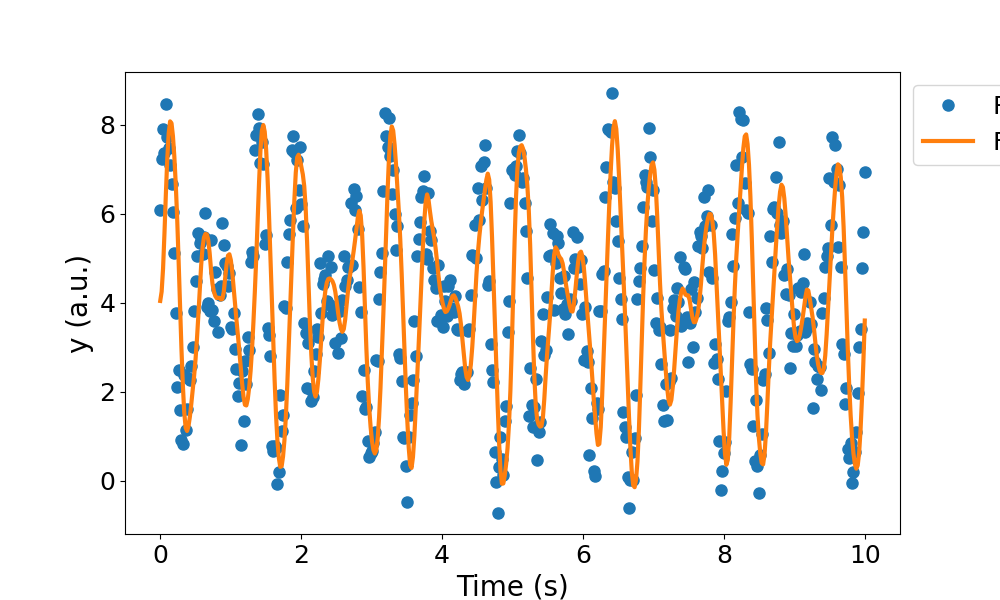

In [14]:
fig, axes = plt.subplots(figsize = (10,6))
axes.plot(t, y, label = 'Raw', marker = 'o', markersize = 8, linewidth = 0)
axes.plot(t, filtered_data, linewidth = 3, label = 'Filtered')
axes.legend(bbox_to_anchor = [1.0,1.0], fontsize = 18)
axes.set_xticklabels(ax.get_xticklabels(), fontsize = 18);
axes.set_yticklabels(ax.get_xticklabels(), fontsize = 18);
axes.set_xlabel('Time (s)', fontsize = 20)
axes.set_ylabel('y (a.u.)', fontsize = 20)

# Supervised Regression 

## Standard Curve fitting

Now suppose we want to instead fit a function to the dataset. We can utilize scipy to do this, specifically functions within scipy.optimize. We shall try to do this for the above dataset, to fit two sin functions

In [15]:
#Import the library reqired
from scipy.optimize import curve_fit

#First we need to define the fitting function.

def two_sin_funcs(t, f1, phi1, f2, phi2):
    
    y = np.sin(2*np.pi*f1*t + phi1) + np.sin(2*np.pi*f2*t + phi2)
    
    return y

lb = (0,-np.pi/2, 0, -np.pi/2) #lower bounds
ub = (1E4,np.pi/2, 1E4, np.pi/2) #upper bounds

popt, pcov = curve_fit(two_sin_funcs, t, y, p0=[1.6, 0.5, 2.0, 0.5], bounds = (lb,ub)) 

#popt and pcov return the optimum values of the parameters and the covariance matrix, respectively
#the curve fitting respects the bounds, and the initial conditions are given by p0


Take a look at the output of the curve fitting.

In [16]:
popt

array([1.60154153, 0.46984588, 1.97033388, 1.57079633])

And take a look at the covariance matrix

In [17]:
pcov

array([[ 1.25368262e-05, -3.98470308e-04,  2.37527185e-06,
        -8.01675694e-05],
       [-3.98470308e-04,  1.66920697e-02, -8.06020422e-05,
         2.99957172e-03],
       [ 2.37527185e-06, -8.06020422e-05,  1.26830606e-05,
        -3.99758196e-04],
       [-8.01675694e-05,  2.99957172e-03, -3.99758196e-04,
         1.66428118e-02]])

We usually care about the diagonal elements...these give us the variances of the fitting parameters themselves

In [18]:
np.diag(pcov)

array([1.25368262e-05, 1.66920697e-02, 1.26830606e-05, 1.66428118e-02])

In [19]:
y_fit = two_sin_funcs(t, *popt) #the star just means provide these elements one at a time to the function.

Text(0.5, 1.0, 'Functional Fit')

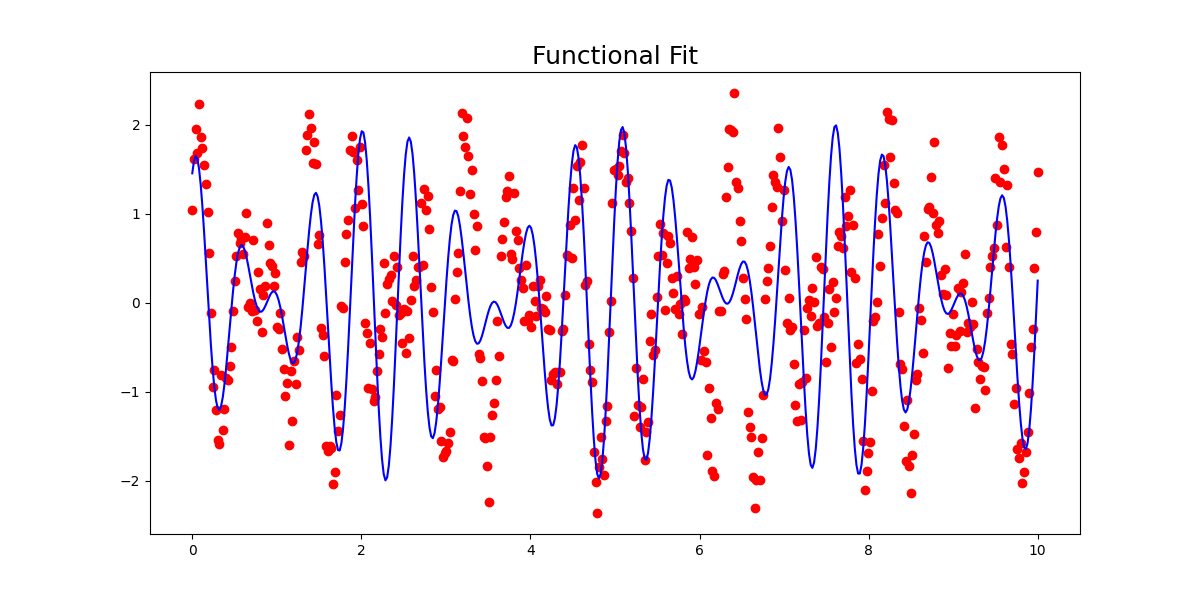

In [20]:
#Let's plot the results of the fitting

fig, axes = plt.subplots(figsize = (12,6))
axes.plot(t,y, 'ro', label = 'Raw')
axes.plot(t, y_fit, 'b-', label = 'Fitted')
axes.set_title('Functional Fit', fontsize = 18)

# Exercise

To test your knowledge, do the following exercise

1. Simulate some kind of  data. E.g., use a polynomial function, or import your own spectral data example
2. Try smoothing the data with a window filter
3. Fit the smoothed and unsmoothed data, and compare the results.


# Supervised regression - Machine Learning

In most instances, however, we will not have underlying functions that we can easily use. In these cases we can use supervised machine learning approaches. The advantage of these methods is that they can be quite easy to apply and can fit very high dimensinonal, highly nonlinear data and can be quite efficient. Their disadvantage is typically interpretibility and that they are not extrapolative (can only really be used to interpolate for most data). 

Let's see how we can do this for the above data, using several machine learning methods:

* Nearest Neighbors
* Decision Trees
* Gaussian Processes

# K Nearest neighbors

A simple machine learning approach is the so called k-nearest neighbors algorithm. This is a very simple algorithm that takes the average value of the k (where k is a user defined integer) number of nearest neighbors in the training set compared to the queried point, and then uses this to estimate the value at that queried point. It is implemented in scikit-learn (<a href = "https://scikit-learn.org/stable/modules/neighbors.html#regression">link</a> for more details). By using the 'distance' weights, points further away from the test point are weighted less than points closer to the test point. 

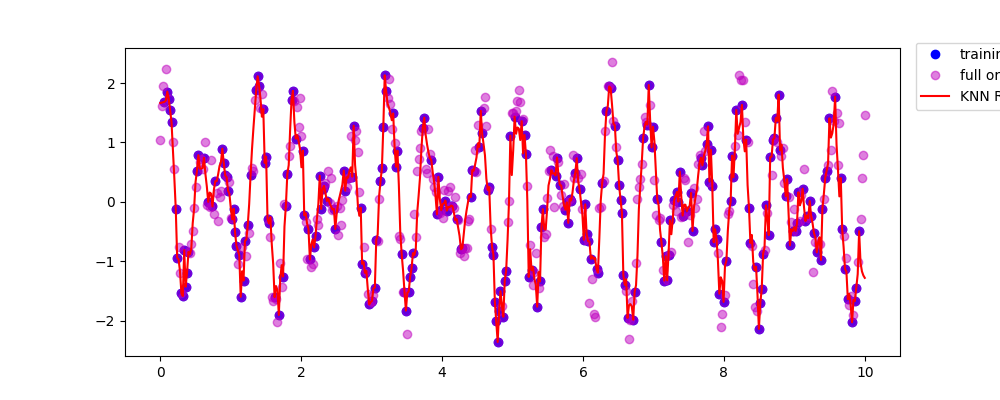

In [21]:
#First, let's only take a subset of the data
subset_size = 0.50 #50% of the data
random_indices = np.random.choice(len(y), size = int(subset_size*len(y)), replace = False)

y_subset = y[random_indices]
X_subset = t[random_indices][:, np.newaxis]

from sklearn import neighbors # k nearest neighbors

knn = neighbors.KNeighborsRegressor(n_neighbors=5, weights="distance")
y_ = knn.fit(X_subset, y_subset).predict(t[:, np.newaxis]) #This fits the model and predicts it on the original axis

fig, axes = plt.subplots(nrows=1,ncols=1, figsize = (10,4))
axes.plot(X_subset, y_subset, 'bo', label = 'training')
axes.plot(t, y, 'mo', alpha = 0.5, label = 'full original')
axes.plot(t, y_, 'r-', label = 'KNN Regression')
axes.legend(loc = [1.02, 0.8])

In [22]:
# EXERCISE: See how this performs for different values of train/test splits


# Random Forests and Gaussian Process Regression

Other ML methods for regression include random forests (ensembles of decision trees) and Gaussian Process regression. Due to time considerations we will not explore them in detail here other than to show how to implement them on the dataset above.

In [23]:
from sklearn.ensemble import RandomForestRegressor #random forest regression
from sklearn.gaussian_process import GaussianProcessRegressor #GPR
from sklearn.gaussian_process.kernels import RBF

#First, let's only take a subset of the data
subset_size = 0.50 #50% of the data
random_indices = np.random.choice(len(y), size = int(subset_size*len(y)), replace = False)

rf = RandomForestRegressor(n_estimators = 20) #n_estimators is the number of trees. 
                                            #Play with this to see how accuracy changes

rbf = RBF(length_scale = 2.0, length_scale_bounds=(.25,10))
gpr = GaussianProcessRegressor(kernel=rbf) #play with kernel if needed

y_rf = rf.fit(X_subset, y_subset).predict(t[:, np.newaxis]) #fit random forest regressor
y_gpr = gpr.fit(X_subset, y_subset).predict(t[:, np.newaxis]) #fit GPR This can take a bit of time!



/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.25. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


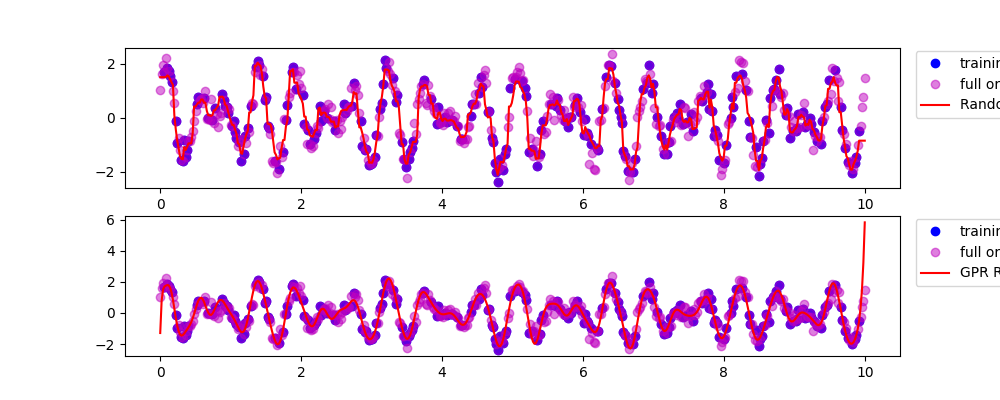

In [24]:
fig, axes = plt.subplots(nrows=2,ncols=1, figsize = (10,4))
axes[0].plot(X_subset, y_subset, 'bo', label = 'training')
axes[0].plot(t, y, 'mo', alpha = 0.5, label = 'full original')
axes[0].plot(t, y_rf, 'r-', label = 'Random Forest Regression')
axes[0].legend(loc = [1.02, 0.5])

axes[1].plot(X_subset, y_subset, 'bo', label = 'training')
axes[1].plot(t, y, 'mo', alpha = 0.5, label = 'full original')
axes[1].plot(t, y_gpr, 'r-', label = 'GPR Regression')
axes[1].legend(loc = [1.02, 0.5])

# Exercise

To test your knowledge, do the following exercise

1. Change the number of estimators in the random forest regressor, and change the kernel type in the GPR
2. Compare the accuracy as a function of the hyperparameters changed in (1). Plot the results. What do you notice?
3. How might you detect overfitting in your model?


# Linear decomposition methods: PCA, NMF, ICA

In [25]:
from copy import deepcopy as dc

import numpy as np
from sklearn import decomposition

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Download EELS data. This is 12 EELS spectral data sets of indium-tin oxide cubes aquired by Kevin Roccapriore, measured at different resolutions and geometries. Pick the one you like!

In [26]:
%%capture
!wget https://www.dropbox.com/s/nicyvttpihzh1cd/Plasmonic_sets_7222021_fixed.npy
loadedfile = np.load("Plasmonic_sets_7222021_fixed.npy", allow_pickle=True).tolist()

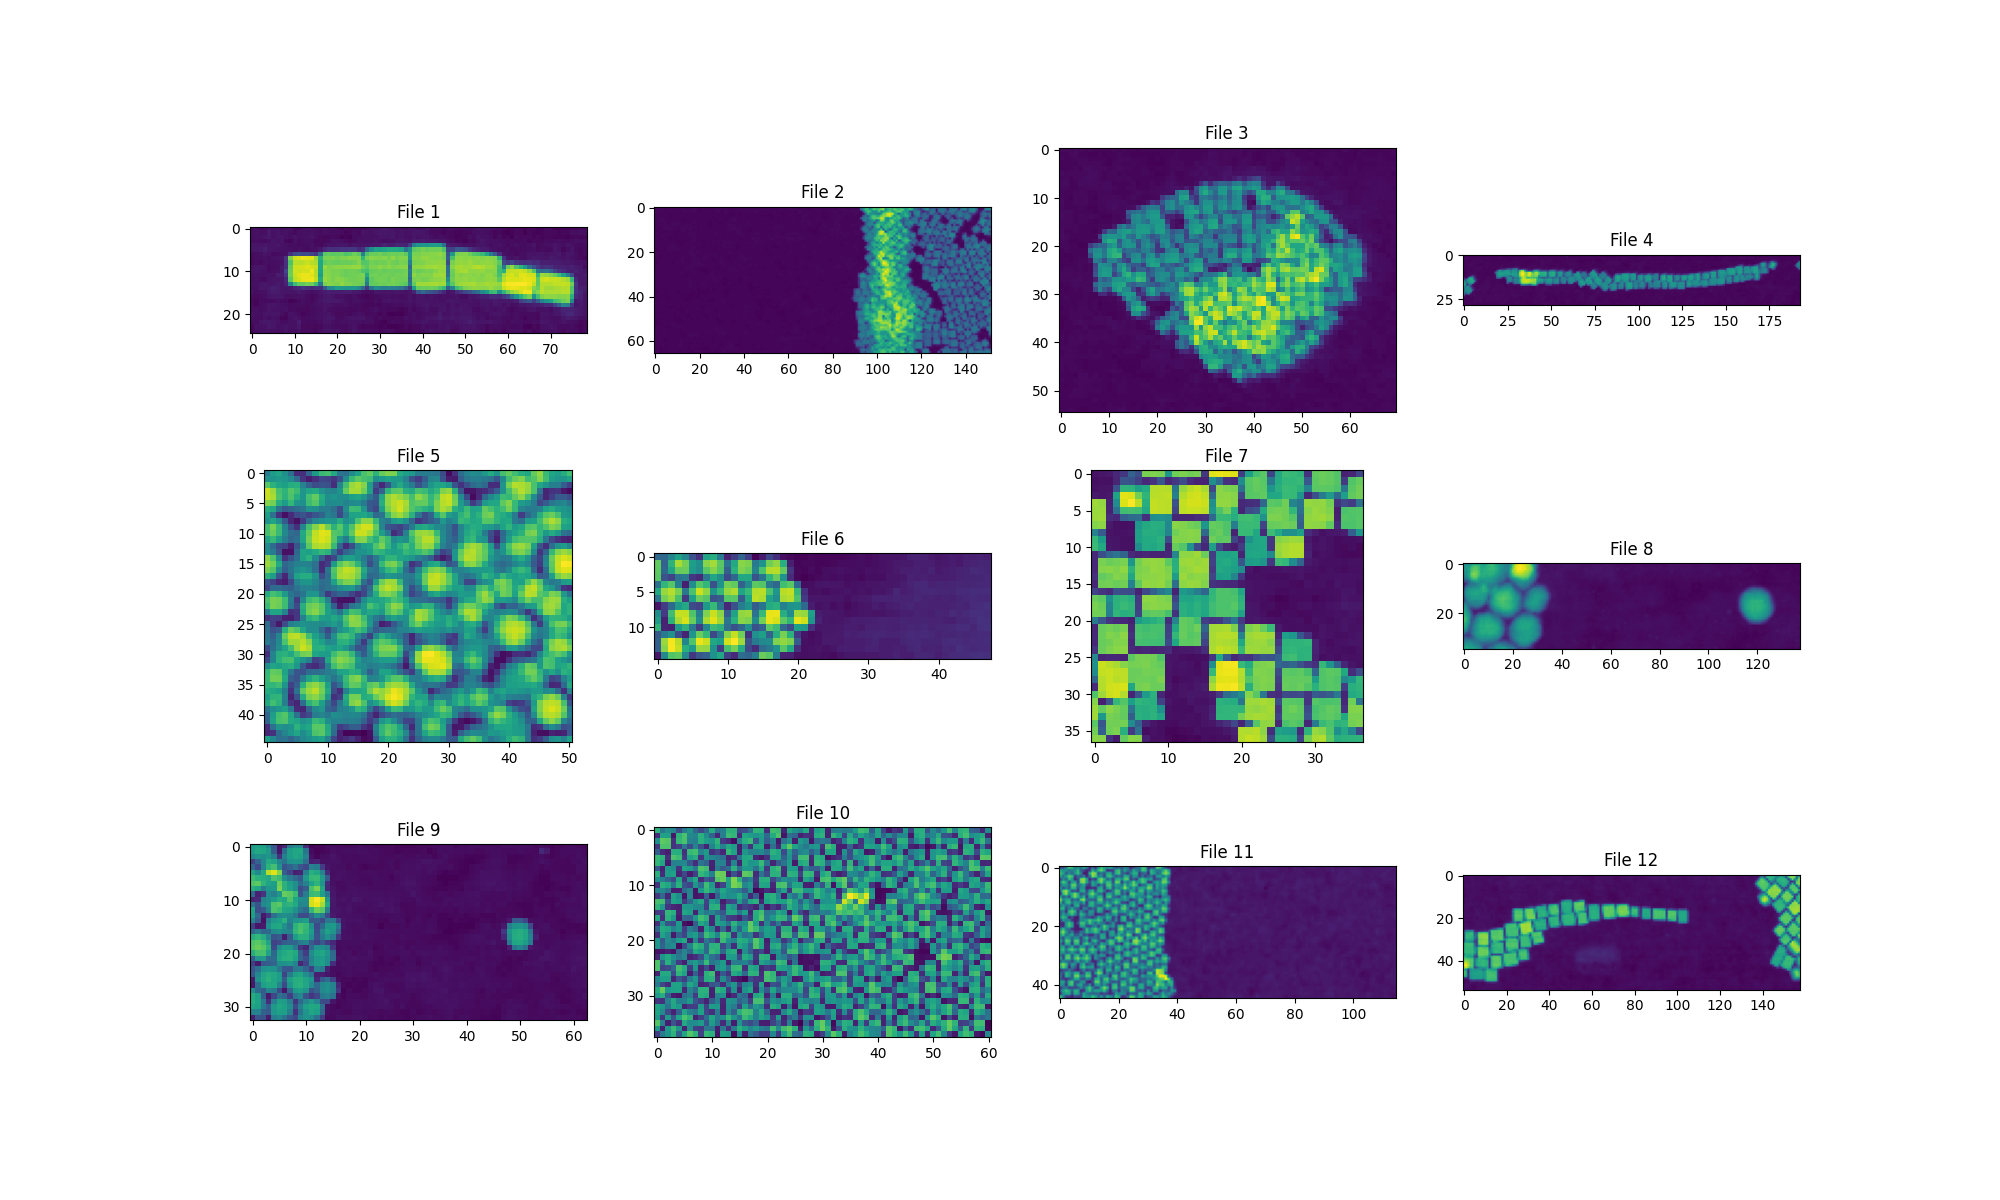

In [27]:
num_im = len(loadedfile)
rows = int(np.ceil(float(num_im)/4))
cols = int(np.ceil(float(num_im)/rows))

gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize = (5*cols, 3*(1+rows))) 
  
for kk in range(num_im):
    ax = fig.add_subplot(gs[kk])
    fileset  = loadedfile['{}'.format(kk+1)]
    f1,f2,f3,f4 = fileset
    img, data, e_ax, img_scale = fileset[f1], fileset[f2], fileset[f3], fileset[f4]
    ax.imshow(img)
    ax.set_title("File {}".format(kk+1))

In [28]:
# Choose the file for analysis

k = 3
img = loadedfile['{}'.format(k)]['image']
specim = loadedfile['{}'.format(k)]['spectrum image']
e_ax = loadedfile['{}'.format(k)]['energy axis']
imscale = loadedfile['{}'.format(k)]['scale']

In [29]:
# Read grid spectoscopy data

hdata = specim
hdata = hdata.astype(np.float64)

Visual inspection of the :

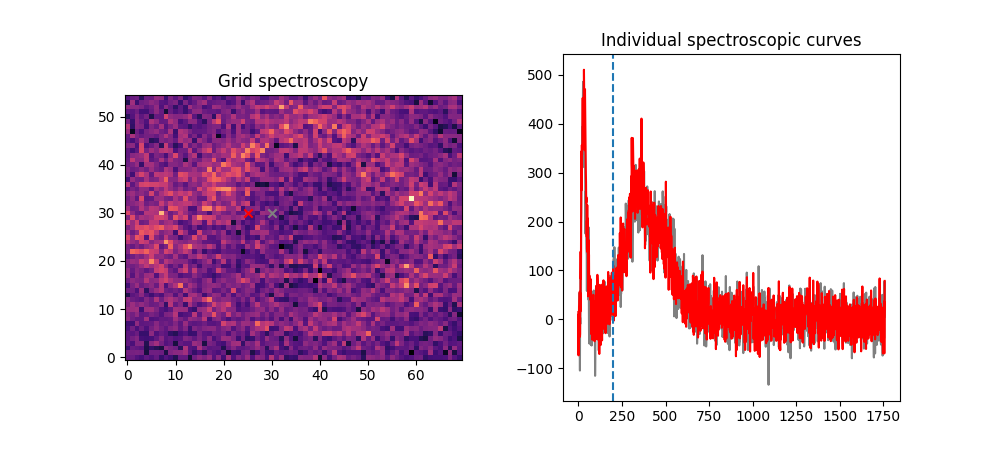

In [30]:
# Select a slice and points for extracting idividual spectoscopic curves
# For convenience, we look at the data in pixels (however, we store the real scale as e_ax)

s = 200 # slice
pos1 = [30, 30]
pos2 = [25, 30]

# Plot
_, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(hdata[..., s], cmap='magma', origin="lower")
ax[0].scatter(pos1[0], pos1[1], c='gray', marker='x')
ax[1].plot(hdata[pos1[1], pos1[0], :], c='gray')
ax[0].scatter(pos2[0], pos2[1], c='red', marker='x')
ax[1].plot(hdata[pos2[1], pos2[0], :], c='red')
ax[1].axvline(x=s, linestyle = '--')
ax[0].set_title('Grid spectroscopy')
ax[1].set_title('Individual spectroscopic curves')
plt.subplots_adjust(wspace=.3)

Very important considerations for subsequent analysis.
 - Make sure that before any subsequent analysis the data is properly curated. For EELS this is zero loss peak subtraction and log-log deconvolution. This will affect analysis very strongly (e.g. zerol-loss peak will dominate everything if not accounted for).
 - You can also consider downsampling the data (just average pool). 
 - Finally, always keep track on whether you normalize data and how (all spectra 0 to 1, or all normalized to total maximum)
 - And keep track on whether average is subtracted. 
 - Normalization and average subtraction will affect the analysis results. In our experience, there is no right way or worng way for doing it - different preprocessing highlights dissimilar aspects of the physics of the system. However, it is important to keep track of these.  

# PCA and NMF

As a first step, it is always a good idea to perform exploratory data analysis. Here, we use the standard principal component analysis and non-negative matrix factorization. 

In [31]:
X_vec = hdata.copy()
d1, d2, d3 = X_vec.shape
X_vec = X_vec.reshape(d1*d2, d3)
X_vec = (X_vec - np.min(X_vec)) / np.ptp(X_vec)

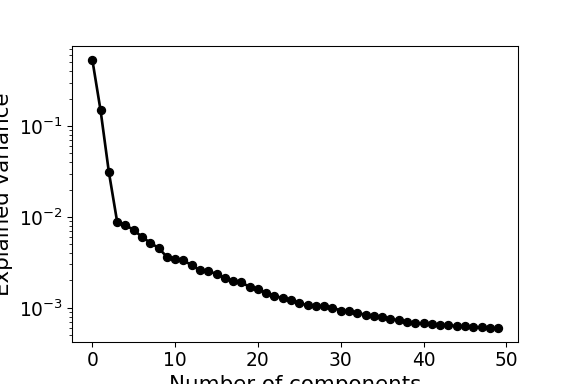

In [32]:
pca = decomposition.PCA()
pca.fit(X_vec)
plt.figure(figsize=(6, 4), dpi = 96)
plt.plot(pca.explained_variance_ratio_[0:50], '-o', linewidth=2, c = 'black')
plt.xlabel('Number of components', fontsize = 16)
plt.ylabel('Explained variance', fontsize = 16)

plt.tick_params(labelsize = 14)
plt.yscale('log')

In [33]:
# Select number of components
nc = 10

# Select decomposition type ('PCA' or 'NMF')
decomposition_type = 'PCA'

# Run decomposition
if decomposition_type == 'NMF':
    clf = decomposition.NMF(n_components=nc, random_state=42)
elif decomposition_type == 'PCA':
    clf = decomposition.PCA(n_components=nc, random_state=42)
else:
    raise NotImplementedError('Available methods: "PCA", "NMF"')
X_vec_t = clf.fit_transform(X_vec)
components = clf.components_
components = components.reshape(nc, d3)
print(components.shape, X_vec_t.shape)

(10, 1758) (3850, 10)


NUMBER OF COMPONENTS: 10
Components...


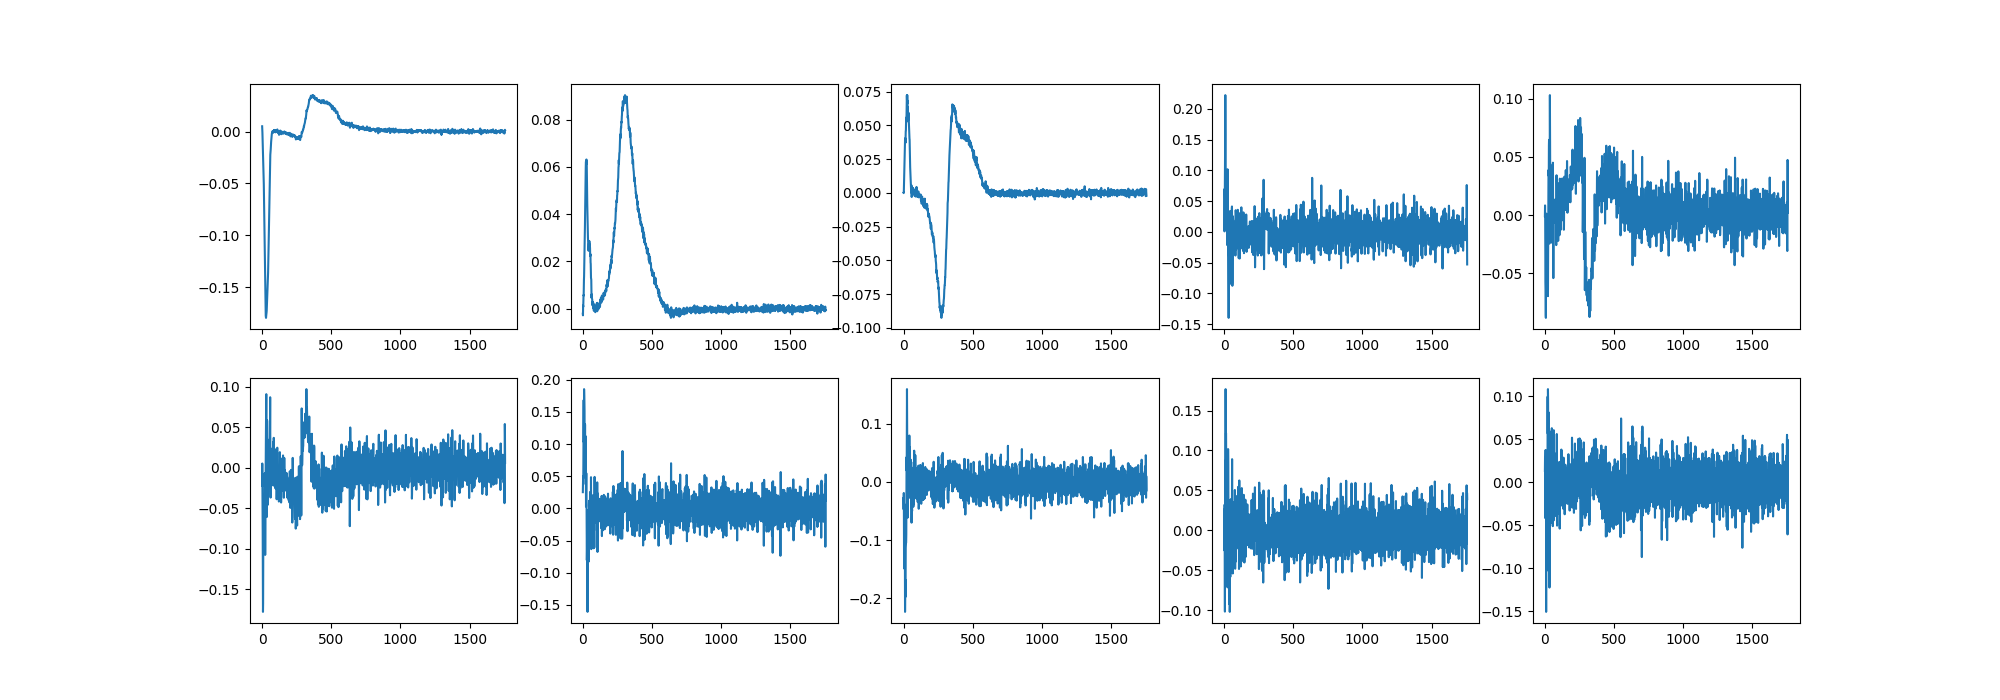

Abundance maps...


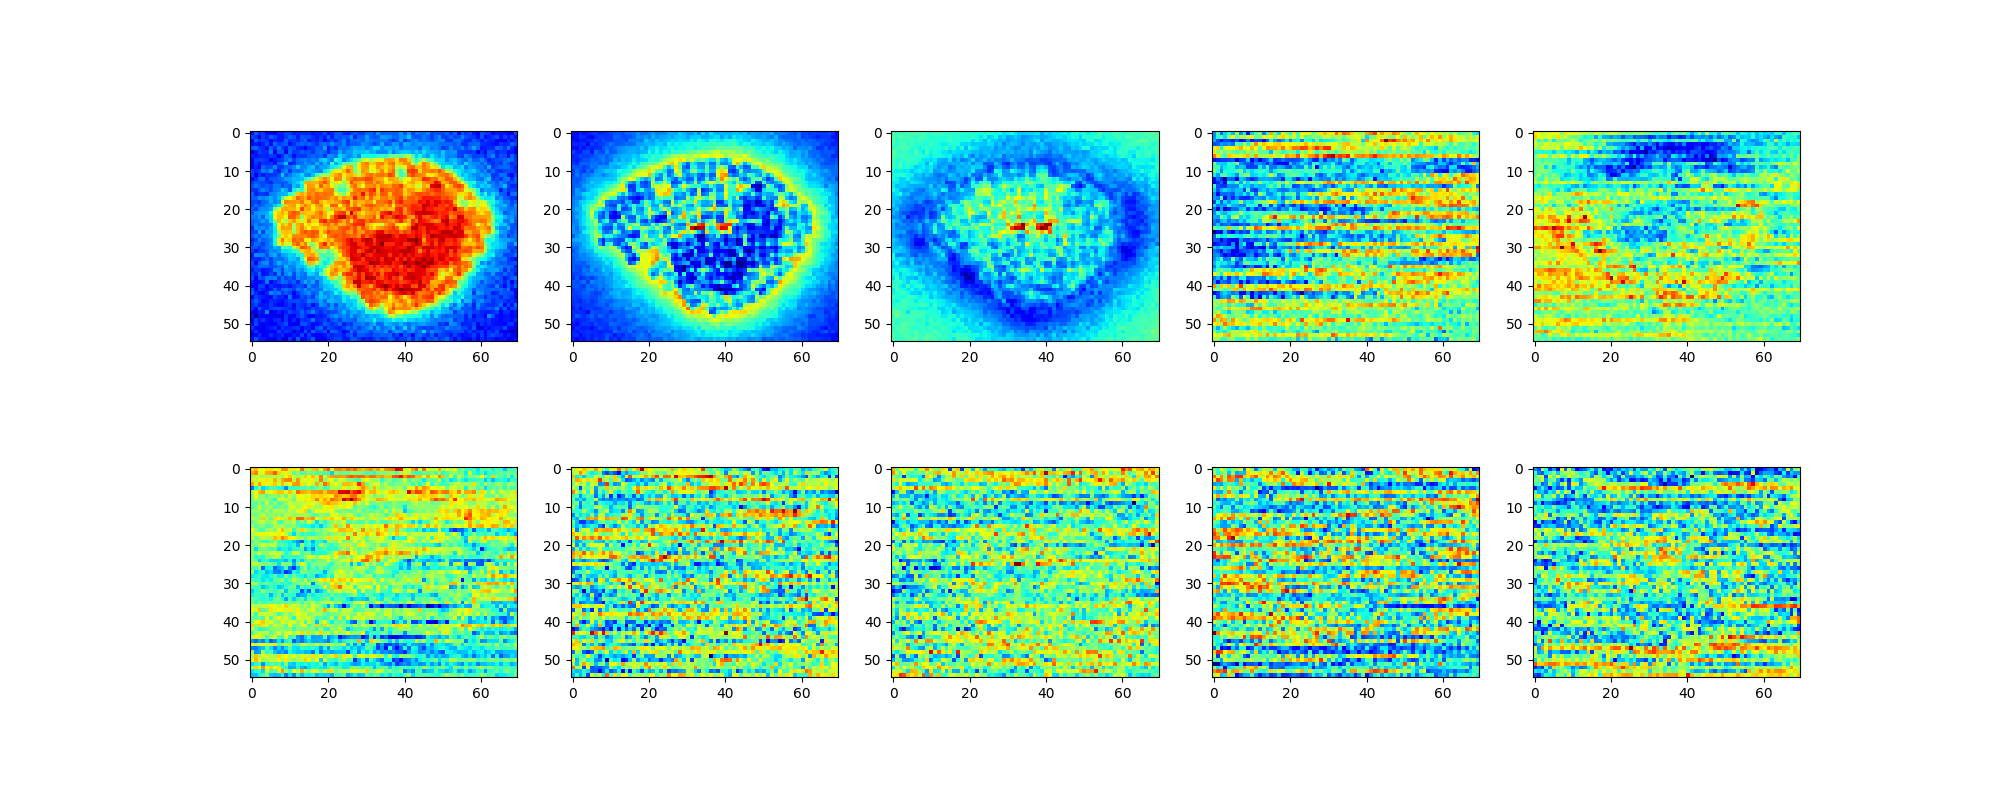

In [34]:
rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))

print('NUMBER OF COMPONENTS: ' + str(nc))
print('Components...')
gs1 = gridspec.GridSpec(rows, cols)
fig1 = plt.figure(figsize = (4*cols, 3.5*(1+rows)//1.5))   
for i in range(nc):
    ax1 = fig1.add_subplot(gs1[i])
    ax1.plot(components[i])
    #ax1.set_title('Component ' + str(i + 1))
plt.show()

print('Abundance maps...')
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))   
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(X_vec_t[:, i].reshape(d1, d2), cmap = 'jet')
    #ax2.set_title('Component ' + str(i + 1))
plt.show()

# Clustering methods: K-means clustering, Gaussian mixture models

Finally, we can also perform clustering or Gaussian mixture modeling to better visualize what is occurring in these datasets. K-Means is a simple algorithm that attempts to assign labels to each spectrum, such that the within-cluster sum of squares is minimized, i.e. the variance in each cluster is minimial. This unsupervised ML algorithm is very powerful.

Similarly, if one has data that is expected to be from multiple gaussian distributions (or can be approximated as such), Gaussian mixture model can be used to assign each datapoint to one of these Gaussian distributions and learn the parameters of these distributions (means, covariances). This can also be very helpful to observe changes in behaviors. Let's try these on the above dataset.

# K Means Clustering

Here we will do k-means clustering by using the scikit-learn package

In [35]:
## import library
from sklearn.cluster import KMeans

km = KMeans(n_clusters=4) #choose number of clusters
km_results = km.fit(np.array(X_vec)) #we can intelligently fold the data and perform Kmeans

#Get the cluster centers and the labels
km_labels = km_results.labels_
km_centers = km_results.cluster_centers_

#Reshape the labels
km_labels = km_labels.reshape(d1, d2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<ipython-input-36-1c6ab946dcef>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', km.n_clusters) #make a colormap, number of colors being the number of clusters


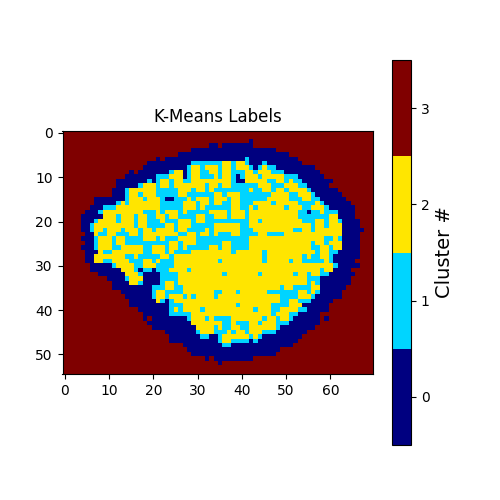

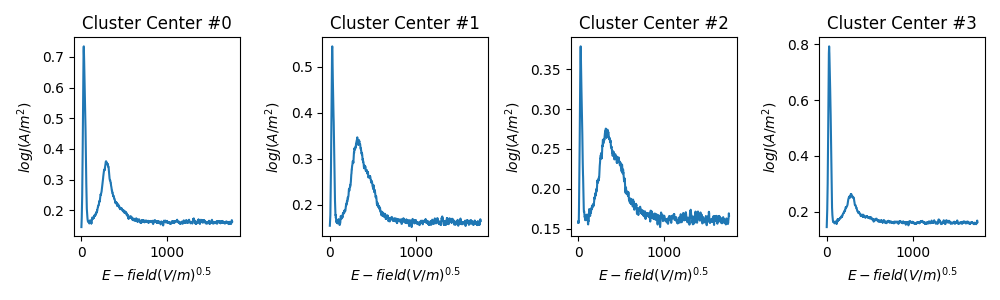

In [36]:
#Plot the results

#Plot the labels
cmap = plt.cm.get_cmap('jet', km.n_clusters) #make a colormap, number of colors being the number of clusters

#Plot the cluster labels
fig, axes = plt.subplots(figsize=(5,5))
im = axes.imshow(km_labels, cmap=cmap,vmin=np.min(km_labels) - 0.5, 
                      vmax=np.max(km_labels) + 0.5)
axes.set_title('K-Means Labels')
cbar = fig.colorbar(im, ax=axes)
cbar.ax.set_yticks(np.arange(np.min(km_labels), np.max(km_labels) + 1))
cbar.ax.set_ylabel("Cluster #", fontsize = 14)

#Plot the cluster centers
fig, axes = plt.subplots(nrows=1, ncols=km.n_clusters, figsize = (10,3))
for ind, ax in enumerate(axes.flat):
    ax.plot(km_centers[ind,:])
    ax.set_title('Cluster Center #' + str(ind))
    ax.set_ylabel("$log J (A/m^2)$")
    ax.set_xlabel("$E-field (V/m)^{0.5}$")
fig.tight_layout()

## Gaussian mixture modeling

Now we will perform Gaussian mixture modeling

In [37]:
## import library
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4,covariance_type="diag") #choose number of components

gmm_results = gmm.fit(np.array(X_vec)) #we can intelligently fold the data and perform GM
gmm_labels = gmm_results.fit_predict(X_vec)
gmm_means = gmm_results.means_


<ipython-input-38-f916221aed64>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', gmm.n_components) #make a colormap, number of colors being the number of clusters


Text(0, 0.5, 'GMM Label')

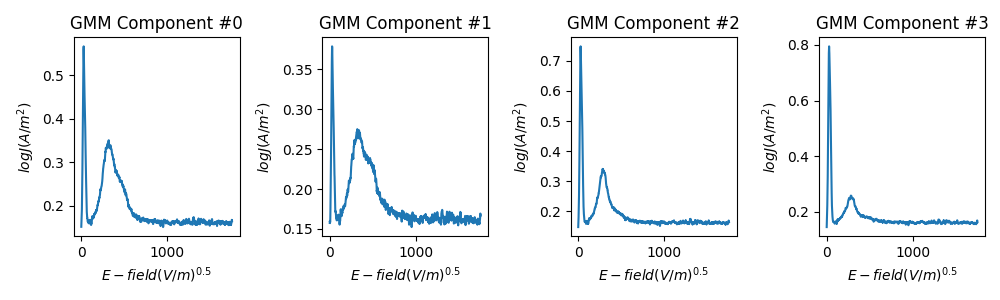

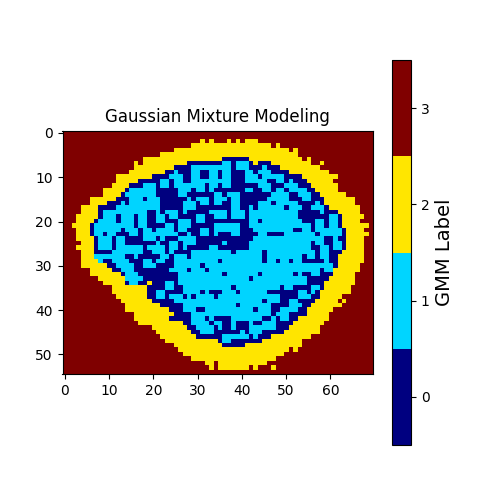

In [38]:
gmm_labels= gmm_labels.reshape(d1, d2)

#Plot the GMM means
fig, axes = plt.subplots(nrows=1, ncols=gmm.n_components, figsize = (10,3))
for ind, ax in enumerate(axes.flat):
    ax.plot(gmm_means[ind,:])
    ax.set_title('GMM Component #' + str(ind))
    ax.set_ylabel("$log J (A/m^2)$")
    ax.set_xlabel("$E-field (V/m)^{0.5}$")
fig.tight_layout()

#Plot the labels
cmap = plt.cm.get_cmap('jet', gmm.n_components) #make a colormap, number of colors being the number of clusters

#Plot the cluster labels
fig, axes = plt.subplots(figsize=(5,5))
im = axes.imshow(gmm_labels, cmap=cmap,vmin=np.min(gmm_labels) - 0.5, 
                      vmax=np.max(gmm_labels) + 0.5)
axes.set_title('Gaussian Mixture Modeling')
cbar = fig.colorbar(im, ax=axes)
cbar.ax.set_yticks(np.arange(np.min(gmm_labels), np.max(gmm_labels) + 1))
cbar.ax.set_ylabel("GMM Label", fontsize = 14)

In [39]:
print('Weights of the GMM are ' + str(gmm.weights_))

Weights of the GMM are [0.18076338 0.26573012 0.19224559 0.3612609 ]


## Exercises

1. Play with number of components/clusters and see how the results differ. Think about how you might be able to determine the appropriate number of clusters/components.

2. What is the main difference between the I-V curves based on the components? (E.g., try linear fits through each component and find the differences in slope).

3. It is often better to perform GMM on a much smaller feature space. Use PCA to reduce the dimensionality to 2, and then perform GMM. Then plot the density estimation from the model (see the scikit-learn documentation <a href="https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html">here</a>).
